===================================================
### Code developed by: Jieyi Tang

### Contact: 516643820@qq.com
===================================================

Since the code is running on Colab, the file path is mounted to Google Drive. Reset path if you want to reproduce the results locally.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/forth week/cases")

# Import dependent libraries

In [7]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import time

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Load data


In [8]:
import joblib
# PCA model
pca_model = joblib.load('pca_model_time576_com95_1.pkl')
#scaler for spatial data
fields = ['CO2','Velocity_x','Velocity_y','Velocity_z','Temperature','Humidity','Virus1']
for j in range(1,9):
  for i in fields:
    locals()['scaler_model_'+i+'_'+str(j)]=joblib.load('scaler_spatial_whole_model_'+i+'_'+str(j)+'.pkl')
# POD coefficients
X_pca_1 = joblib.load('pod_coefficients_whole_time720_com95_1.pkl')
X_pca_2 = joblib.load('pod_coefficients_whole_time720_com95_2.pkl')
X_pca_3 = joblib.load('pod_coefficients_whole_time720_com95_3.pkl')
X_pca_4 = joblib.load('pod_coefficients_whole_time720_com95_4.pkl')
X_pca_5 = joblib.load('pod_coefficients_whole_time720_com95_5.pkl')
X_pca_6 = joblib.load('pod_coefficients_whole_time720_com95_6.pkl')
X_pca_7 = joblib.load('pod_coefficients_whole_time720_com95_7.pkl')
X_pca_8 = joblib.load('pod_coefficients_whole_time720_com95_8.pkl')

X_pca = np.vstack((X_pca_1,X_pca_2,X_pca_3,X_pca_4,X_pca_5,X_pca_6,X_pca_7,X_pca_8))


In [ ]:
X_pca.shape

(5760, 95)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler_pca_model= MinMaxScaler((0,1))
X_pca_scaled = scaler_pca_model.fit_transform(X_pca)
np.allclose(X_pca, scaler_pca_model.inverse_transform(X_pca_scaled))

True

In [10]:
X_pca_all = np.vsplit(X_pca_scaled, 8)
np.shape(X_pca_all)

(8, 720, 95)

In [ ]:
fan_1 = np.load('fan_data_720_1.npy')
fan_2 = np.load('fan_data_720_2.npy')
fan_3 = np.load('fan_data_720_3.npy')
fan_4 = np.load('fan_data_720_4.npy')
fan_5 = np.load('fan_data_720_5.npy')
fan_6 = np.load('fan_data_720_6.npy')
fan_7 = np.load('fan_data_720_7.npy')
fan_8 = np.load('fan_data_720_8.npy')

In [ ]:
for j in range(1,9):
  locals()['fan_'+str(j)][:,2] -= 290
  locals()['fan_'+str(j)][:,2] /= 10

Simulation Sensor Data

In [ ]:
fields = ['CO2','velocity_x','velocity_y','velocity_z','temperature','humidity','virus1']
for j in range(1,9):
  locals()['sensor_'+str(j)] = np.load('case'+str(j)+'_sensor.npy')
  for i in range(7):
    locals()['sensor_'+str(j)+'_'+fields[i]] = locals()['sensor_'+str(j)][:,:,i]

In [ ]:
sensor_1.shape

(720, 18, 7)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
for j in range(1,9):
  locals()['norm_sensor_'+str(j)] =np.zeros([720,7,18])
  for i in range(7):
    locals()['scalar_'+str(j)+'_'+fields[i]] = MinMaxScaler((0,1))
    locals()['norm_'+str(j)+'_'+fields[i]] = locals()['scalar_'+str(j)+'_'+fields[i]].fit_transform(locals()['sensor_'+str(j)+'_'+fields[i]][:,:])
    locals()['norm_sensor_'+str(j)][:,i,:] = locals()['norm_'+str(j)+'_'+fields[i]][:,:]
  locals()['norm_sensor_'+str(j)] = locals()['norm_sensor_'+str(j)].reshape(720,18*7)
for j in range(8):
  locals()['X_train_'+str(j+1)] = np.hstack((X_pca_all[j],locals()['norm_sensor_'+str(j+1)],locals()['fan_'+str(j+1)]))
X_train = np.vstack((X_train_1,X_train_2,X_train_3,X_train_4,X_train_5,X_train_6,X_train_7,X_train_8))
print(X_train.shape)

(5760, 224)


In [ ]:
X_train

array([[  0.87516544,   0.88802001,   0.81685273, ...,   0.5       ,
          1.        ,   0.8       ],
       [  0.88167687,   0.94778132,   0.93131345, ...,   0.5       ,
          1.        ,   0.8       ],
       [  0.887575  ,   1.        ,   0.92855817, ...,   0.5       ,
          1.        ,   0.8       ],
       ...,
       [  0.04973729,   0.44367576,   0.29739687, ...,   0.        ,
          0.        , -29.        ],
       [  0.04943898,   0.4442029 ,   0.2979948 , ...,   0.        ,
          0.        , -29.        ],
       [  0.04915039,   0.44507807,   0.29869469, ...,   0.        ,
          0.        , -29.        ]])

## Combine data and process it into a form grouped by consecutive time steps

In [ ]:
X = np.vsplit(X_train, 8)
np.shape(X)

(8, 720, 224)

In [ ]:
def concat_timesteps(X_train, ntimes, step):
    X_train_concat = []
    for i in range(len(X_train) - ntimes*step):
        X_train_concat.append(X_train[i:i+ntimes*step:step])
    return np.array(X_train_concat)

In [ ]:
codings_size = X_train.shape[1]
ncoeffs = X_pca_1.shape[1] # number of POD coefficients
ntimes = 9 # consecutive times for the AAE
step = 1 # step between times
X_1 = concat_timesteps(X[0], ntimes, step)
X_2 = concat_timesteps(X[1], ntimes, step)
X_3 = concat_timesteps(X[2], ntimes, step)
X_4 = concat_timesteps(X[3], ntimes, step)
X_5 = concat_timesteps(X[4], ntimes, step)
X_6 = concat_timesteps(X[5], ntimes, step)
X_7 = concat_timesteps(X[6], ntimes, step)
X_8 = concat_timesteps(X[7], ntimes, step)

# X_train_concat = np.vstack((X_1,X_2,X_3,X_4,X_5))
X_train_concat = X_1
# X_train_concat = X_7
print("X_concat: ", np.shape(X_train_concat))
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes)
print("X_concat_flatten: ", np.shape(X_train_concat_flatten))
X_train_4d = X_train_concat.reshape((X_train_concat.shape[0], ntimes, X_train_concat.shape[2], 1))
print("X_4d: ", X_train_4d.shape)

X_concat:  (711, 9, 224)
X_concat_flatten:  (711, 2016)
X_4d:  (711, 9, 224, 1)


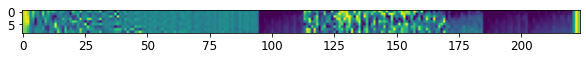

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(X_train_concat[3, :,:])

In [ ]:
# We experimented with 16, 32, 64, 128, 256, and finally chose 32
BATCH_SIZE = 128

X_train_4d = X_train_4d.astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(X_train_4d)
train_dataset = train_dataset.shuffle(len(X_train_concat))
train_dataset = train_dataset.batch(BATCH_SIZE)
for data in train_dataset:
    print(data)
    break

tf.Tensor(
[[[[0.3657841 ]
   [0.11723434]
   [0.51940787]
   ...
   [0.5       ]
   [1.        ]
   [0.8       ]]

  [[0.3649521 ]
   [0.11929669]
   [0.520117  ]
   ...
   [0.5       ]
   [1.        ]
   [0.8       ]]

  [[0.36463654]
   [0.12054511]
   [0.51632184]
   ...
   [0.5       ]
   [1.        ]
   [0.8       ]]

  ...

  [[0.36272275]
   [0.12129828]
   [0.51499313]
   ...
   [0.5       ]
   [1.        ]
   [0.8       ]]

  [[0.36216128]
   [0.12227037]
   [0.5139422 ]
   ...
   [0.5       ]
   [1.        ]
   [0.8       ]]

  [[0.36168966]
   [0.12224912]
   [0.51556826]
   ...
   [0.5       ]
   [1.        ]
   [0.8       ]]]


 [[[0.29202622]
   [0.20105767]
   [0.46989563]
   ...
   [0.5       ]
   [1.        ]
   [0.8       ]]

  [[0.29097518]
   [0.20150444]
   [0.47216016]
   ...
   [0.5       ]
   [1.        ]
   [0.8       ]]

  [[0.2899177 ]
   [0.20191197]
   [0.47397542]
   ...
   [0.5       ]
   [1.        ]
   [0.8       ]]

  ...

  [[0.28624234]
   [0.204885

# Assimilate data and Control with AAE

### load model

In [ ]:
from tensorflow.keras.models import load_model
ae = load_model('ae_large_model_train_5000_latent_space_500_control.h5')
encoder, decoder = ae.layers

latent_size = 500

### functions used

In [ ]:
def mse_loss(inp, outp):
    """
    Calculate mean square error 
    between real value and prediction
    
    Parameters
    ----------
    inp : numpy.ndarray 
       real POD coefficients
    ontp : numpy.ndarray
       generated values of the POD coefficients

    Returns
    -------
    float
       mean squared loss between inp and outp 
    """   
    # inp = tf.reshape(inp, [-1, codings_size])[:,:pca_size]*np.sqrt(weight_pod)
    inp = tf.reshape(inp, [-1, codings_size])[:,:]
    # outp = tf.reshape(outp, [-1, codings_size])[:,:pca_size]*np.sqrt(weight_pod)
    outp = tf.reshape(outp, [-1, codings_size])[:,:]
    pod_loss = tf.keras.losses.MeanSquaredError()(inp,outp)
    return pod_loss

def process_obs_data(march_range, X_obs):
    """
    Process the observation data to be 
    in the range of the forward/backward march
    
    Parameters
    ----------
    march_range : numpy.ndarray 
       the time levels covered by the current forecast
    X_obs : numpy.ndarray
       all observation data
       
    Returns
    -------
    numpy.ndarray
       observation data in the forward/backward march   
    """   
    obs_data = []
    for x in range(len(X_obs)):
        if X_obs[x,0] in march_range:
            obs_data.append(X_obs[x])
    
    # Convert the time level to the range {0 - (m-1)}
    obs_data = np.array(obs_data)
    for i in range(len(obs_data)):
        obs_data[i,0] = obs_data[i,0] - march_range[0]

    #print('obs_data in march range: ', obs_data)    
    return obs_data

### Replace method

In [ ]:
beta1 = 1
beta2 = 2

In [ ]:
def predict_coding_forward_basic(initial_pred, real_coding, epochs=10):
    """
    Generate predictions of m consecutive time levels:
    use {0-(m-2)} to predict m-1
    
    Parameters
    ----------
    initial_pred : numpy.ndarray 
       initial guess of m consecutive time levels
    real_coding : numpy.ndarray
       real value of {0 - (m-2)} consecutive time levels
    epochs: int
       times of update iteration
       
    Returns
    -------
    numpy.ndarray
       predictions for m consecutive time levels
    float
       mean squared loss of the last iteration   
    """   
    loss = []
    # The prediction is fed into the AAE as input, and updated through iteration
    for epoch in range(epochs):
        encoder_output = encoder(initial_pred, training=False)
        decoder_output = decoder(encoder_output, training=False)
        pod_loss=mse_loss(real_coding, decoder_output[:,:(ntimes - 1),:,:]).numpy()
        # loss.append(pod_loss+obs_loss)
        loss.append(pod_loss)
        # Replace the value at the last time step of the initial input 
        # with the result at the last time step of the predicted result        
        initial_pred[:,(ntimes - 1):,:,:] = decoder_output[:,(ntimes - 1):,:,:]        
        
    return decoder_output,loss


def predict_coding_forward(initial_pred, real_coding, obs_data, relaxation, epochs=10):
    """
    Generate predictions of m consecutive time levels:
    use {0-(m-2)} to predict m-1
    
    Parameters
    ----------
    initial_pred : numpy.ndarray 
       initial guess of m consecutive time levels
    real_coding : numpy.ndarray
       real value of {0 - (m-2)} consecutive time levels
    obs_data : numpy.ndarray
       observation data given by sensors
    epochs: int
       times of update iteration
       
    Returns
    -------
    numpy.ndarray
       predictions for m consecutive time levels
    float
       mean squared loss of the last iteration   
    """     
    loss = []
    # The prediction is fed into the AAE as input, and updated through iteration    
    for epoch in range(epochs):
        encoder_output = encoder(initial_pred, training=False)
        decoder_output = decoder(encoder_output, training=False)
        pod_loss=mse_loss(real_coding, decoder_output[:,:(ntimes - 1),:,:]).numpy()
        # obs_loss=obs_mse_loss(real_coding, decoder_output[:,:(ntimes - 1),:,:]).numpy()
        loss.append(pod_loss)
        # Replace the value at the last time step of the initial input 
        # with the result at the last time step of the predicted result         
        initial_pred[:,(ntimes - 1):,:,:] = decoder_output[:,(ntimes - 1):,:,:]
 
        # Replace sensors' data in initial input with observation data
        for i in range(len(obs_data)):
            # Find the time level having observation data
            time_level = int(obs_data[i,0])
            # Replace sensors' data in initial input with observation data
            # The weight here is to adjust the influence of observations on the prediction
            # initial_pred[0,time_level,pca_size:-3,0] = (1 - relaxation)*(initial_pred[0,time_level,pca_size:-3,0]) + relaxation*obs_data[i,1:]
            initial_pred[0,time_level,pca_size:pca_size+18,0] = (1 - beta1)*(initial_pred[0,time_level,pca_size:pca_size+18,0]) + beta1*obs_data[i,1:19]
            initial_pred[0,time_level,pca_size+72:pca_size+90,0] = (1 - beta2)*(initial_pred[0,time_level,pca_size+72:pca_size+90,0]) + beta2*obs_data[i,73:91]

    return decoder_output,loss

def predict_coding_backward(initial_pred, real_coding, obs_data, relaxation, epochs=10):
    """
    Generate predictions of m consecutive time levels:
    use {1-(m-1)} to predict 0
    
    Parameters
    ----------
    initial_pred : numpy.ndarray 
       initial guess of m consecutive time levels
    real_coding : numpy.ndarray
       real value of {1 - (m-1)} consecutive time levels
    obs_data : numpy.ndarray
       observation data given by sensors
    epochs: int
       times of update iteration
       
    Returns
    -------
    numpy.ndarray
       predictions for m consecutive time levels
    float
       mean squared loss of the last iteration   
    """   
    loss = []
    # The prediction is fed into the AAE as input, and updated through iteration     
    for epoch in range(epochs):
        encoder_output = encoder(initial_pred, training=False)
        decoder_output = decoder(encoder_output, training=False)
        pod_loss=mse_loss(real_coding, decoder_output[:,1:,:,:]).numpy()
        loss.append(pod_loss)        
        # Replace the value at the first time step of the initial input 
        # with the result at the first time step of the predicted result         
        initial_pred[:,:1,:,:] = decoder_output[:,:1,:,:]

        # Replace sensors' data in initial input with observation data
        for i in range(len(obs_data)):
            # Find the time level having observation data
            time_level = int(obs_data[i,0])
            # Replace sensors' data in initial input with observation data
            # The weight here is to adjust the influence of observations on the prediction
            # initial_pred[0,time_level,pca_size:-3,0] = (1-relaxation) *(initial_pred[0,time_level,pca_size:-3,0]) + relaxation*obs_data[i,1:]
            initial_pred[0,time_level,pca_size:pca_size+18,0] = (1 - beta1)*(initial_pred[0,time_level,pca_size:pca_size+18,0]) + beta1*obs_data[i,1:19]
            initial_pred[0,time_level,pca_size+72:pca_size+90,0] = (1 - beta2)*(initial_pred[0,time_level,pca_size+72:pca_size+90,0]) + beta2*obs_data[i,73:91]

    return decoder_output,loss

In [ ]:
def control_coding_forward(initial_pred, real_coding, control_parameters, epochs=10):
    """
    Generate predictions of m consecutive time levels:
    use {0-(m-2)} to predict m-1
    
    Parameters
    ----------
    initial_pred : numpy.ndarray 
       initial guess of m consecutive time levels
    real_coding : numpy.ndarray
       real value of {0 - (m-2)} consecutive time levels
    obs_data : numpy.ndarray
       observation data given by sensors
    epochs: int
       times of update iteration
       
    Returns
    -------
    numpy.ndarray
       predictions for m consecutive time levels
    float
       mean squared loss of the last iteration   
    """     
    loss = []
    # The prediction is fed into the AAE as input, and updated through iteration    
    for epoch in range(epochs):
        encoder_output = encoder(initial_pred, training=False)
        decoder_output = decoder(encoder_output, training=False)
        pod_loss=mse_loss(real_coding, decoder_output[:,:(ntimes - 1),:,:]).numpy()
        # obs_loss=obs_mse_loss(real_coding, decoder_output[:,:(ntimes - 1),:,:]).numpy()
        loss.append(pod_loss)
        # Replace the value at the last time step of the initial input 
        # with the result at the last time step of the predicted result         
        initial_pred[:,(ntimes - 1):,:,:] = decoder_output[:,(ntimes - 1):,:,:]
 
        #replace control parameters
        initial_pred[0,:,-3:,0] = control_parameters[:,:]

    return decoder_output,loss

def control_coding_backward(initial_pred, real_coding, control_parameters, epochs=10):
    """
    Generate predictions of m consecutive time levels:
    use {1-(m-1)} to predict 0
    
    Parameters
    ----------
    initial_pred : numpy.ndarray 
       initial guess of m consecutive time levels
    real_coding : numpy.ndarray
       real value of {1 - (m-1)} consecutive time levels
    obs_data : numpy.ndarray
       observation data given by sensors
    epochs: int
       times of update iteration
       
    Returns
    -------
    numpy.ndarray
       predictions for m consecutive time levels
    float
       mean squared loss of the last iteration   
    """   
    loss = []
    # The prediction is fed into the AAE as input, and updated through iteration     
    for epoch in range(epochs):
        encoder_output = encoder(initial_pred, training=False)
        decoder_output = decoder(encoder_output, training=False)
        pod_loss=mse_loss(real_coding, decoder_output[:,1:,:,:]).numpy()
        loss.append(pod_loss)        
        # Replace the value at the first time step of the initial input 
        # with the result at the first time step of the predicted result         
        initial_pred[:,:1,:,:] = decoder_output[:,:1,:,:]

        # Replace control parameters in initial input with observation data
        initial_pred[0,:,-3:,0] = control_parameters[:,:]

    return decoder_output,loss

### Back propagation method

In [ ]:
def predict_gd_basic(initial_pred, real_coding,epochs=20):
  loss = []
  optimizer = tf.keras.optimizers.Adam(1e-2)
  encoder_output = encoder(initial_pred, training=False)
  encoder_output = tf.Variable(encoder_output)
  @tf.function
  def opt_step_forward(optimizer, initial_pred, real_coding):
    with tf.GradientTape() as tape:
      tape.watch(encoder_output)
      decoder_output = decoder(encoder_output, training=False)
      initial_loss=mse_loss(real_coding, decoder_output[:,:(ntimes - 1),:,:])
      # obs_loss=obs_mse_loss(real_coding, decoder_output[:,:(ntimes - 1),:,:])
      loss=initial_loss
        # Replace the value at the last time step of the initial input 
        # with the result at the last time step of the predicted result         
    gradient = tape.gradient(loss,encoder_output)
    optimizer.apply_gradients(zip([gradient],[encoder_output]))
    return loss,encoder_output
  for epoch in range(epochs):
    loss1,encoder_output = opt_step_forward(optimizer, initial_pred, real_coding)
    loss.append(loss1)
  decoder_output = decoder(encoder_output, training=False)

  return decoder_output,loss

def predict_gd_forward(initial_pred,real_coding,obs_data,relaxation,epochs=20):
  for i in range(len(obs_data)):
    # Find the time level having observation data
    time_level = int(obs_data[i,0])
    # Replace sensors' data in initial input with observation data
    # The weight here is to adjust the influence of observations on the prediction
    initial_pred[0,time_level,pca_size:-3,0] = (1 - relaxation)*(initial_pred[0,time_level,pca_size:-3,0]) + relaxation*obs_data[i,1:]
    real_coding = initial_pred[:,:-1,:,:]
  loss = []
  optimizer = tf.keras.optimizers.Adam(1e-2)
  encoder_output = encoder(initial_pred, training=False)
  encoder_output = tf.Variable(encoder_output)
  @tf.function
  def opt_step_forward(optimizer, initial_pred, real_coding,obs_data):
    with tf.GradientTape() as tape:
      tape.watch(encoder_output)
      decoder_output = decoder(encoder_output, training=False)
      initial_loss=mse_loss(real_coding, decoder_output[:,:(ntimes - 1),:,:])
      # obs_loss = obs_mse_loss(decoder_output[:,:(ntimes - 1),:,:],obs_data)
      loss=initial_loss 
        # Replace the value at the last time step of the initial input 
        # with the result at the last time step of the predicted result         
    gradient = tape.gradient(loss,encoder_output)
    optimizer.apply_gradients(zip([gradient],[encoder_output]))
    return loss,encoder_output
  for epoch in range(epochs):
    loss1,encoder_output = opt_step_forward(optimizer, initial_pred, real_coding,obs_data)
    loss.append(loss1)
  decoder_output = decoder(encoder_output, training=False)

  return decoder_output,loss

def predict_gd_backward(initial_pred,real_coding,obs_data,relaxation,epochs=20):
  for i in range(len(obs_data)):
    # Find the time level having observation data
    time_level = int(obs_data[i,0])
    # Replace sensors' data in initial input with observation data
    # The weight here is to adjust the influence of observations on the prediction
    initial_pred[0,time_level,pca_size:-3,0] = (1-relaxation) *(initial_pred[0,time_level,pca_size:-3,0]) + relaxation*obs_data[i,1:]
    real_coding = initial_pred[:,1:,:,:]
  loss = []
  optimizer = tf.keras.optimizers.Adam(1e-2)
  encoder_output = encoder(initial_pred, training=False)
  encoder_output = tf.Variable(encoder_output)
  @tf.function
  def opt_step_backward(optimizer, initial_pred, real_coding,obs_data):
    with tf.GradientTape() as tape:
      tape.watch(encoder_output)
      decoder_output = decoder(encoder_output, training=False)
      initial_loss=mse_loss(real_coding, decoder_output[:,1:,:,:])
      # obs_loss = obs_mse_loss(decoder_output[:,1:,:,:],obs_data)
      loss=initial_loss
        # Replace the value at the last time step of the initial input 
        # with the result at the last time step of the predicted result         
    gradient = tape.gradient(loss,encoder_output)
    optimizer.apply_gradients(zip([gradient],[encoder_output]))
    return loss,encoder_output
  for epoch in range(epochs):
    loss1,encoder_output = opt_step_backward(optimizer, initial_pred, real_coding,obs_data)
    loss.append(loss1)
  decoder_output = decoder(encoder_output, training=False)

  return decoder_output,loss

In [ ]:
def control_gd_forward(initial_pred,real_coding,control_parameters,epochs=20):
  initial_pred[0,:,-3:,0] = control_parameters[:,:]
  real_coding = initial_pred[:,:-1,:,:]
  loss = []
  optimizer = tf.keras.optimizers.Adam(1e-2)
  encoder_output = encoder(initial_pred, training=False)
  encoder_output = tf.Variable(encoder_output)
  @tf.function
  def opt_step_forward(optimizer, initial_pred, real_coding):
    with tf.GradientTape() as tape:
      tape.watch(encoder_output)
      decoder_output = decoder(encoder_output, training=False)
      initial_loss=mse_loss(real_coding, decoder_output[:,:(ntimes - 1),:,:])
      # obs_loss = obs_mse_loss(decoder_output[:,:(ntimes - 1),:,:],obs_data)
      loss=initial_loss 
        # Replace the value at the last time step of the initial input 
        # with the result at the last time step of the predicted result         
    gradient = tape.gradient(loss,encoder_output)
    optimizer.apply_gradients(zip([gradient],[encoder_output]))
    return loss,encoder_output
  for epoch in range(epochs):
    loss1,encoder_output = opt_step_forward(optimizer, initial_pred, real_coding)
    loss.append(loss1)
  decoder_output = decoder(encoder_output, training=False)

  return decoder_output,loss

def control_gd_backward(initial_pred,real_coding,control_parameters,epochs=20):
  initial_pred[0,:,-3:,0] = control_parameters[:,:]
  real_coding = initial_pred[:,1:,:,:]
  loss = []
  optimizer = tf.keras.optimizers.Adam(1e-2)
  encoder_output = encoder(initial_pred, training=False)
  encoder_output = tf.Variable(encoder_output)
  @tf.function
  def opt_step_backward(optimizer, initial_pred, real_coding):
    with tf.GradientTape() as tape:
      tape.watch(encoder_output)
      decoder_output = decoder(encoder_output, training=False)
      initial_loss=mse_loss(real_coding, decoder_output[:,1:,:,:])
      # obs_loss = obs_mse_loss(decoder_output[:,1:,:,:],obs_data)
      loss=initial_loss
        # Replace the value at the last time step of the initial input 
        # with the result at the last time step of the predicted result         
    gradient = tape.gradient(loss,encoder_output)
    optimizer.apply_gradients(zip([gradient],[encoder_output]))
    return loss,encoder_output
  for epoch in range(epochs):
    loss1,encoder_output = opt_step_backward(optimizer, initial_pred, real_coding)
    loss.append(loss1)
  decoder_output = decoder(encoder_output, training=False)

  return decoder_output,loss

# Data assimilation case


### Generate obs data

In [ ]:
# Randomly take 400 sets of observation data from the training dataset

import random
# new_norm_sensor = norm_sensor_1[360:720]
times = random.sample(range(0, 720), 500)
times.sort()
#print(times)

X_obs = []
# Get the observation data
for t in times:
    X_obs.append(norm_sensor_1[t])

# Add the corresponding time level to the observation data 
# so that it can be judged whether it is within 
# the time range of march during data assimilation
X_obs = np.array(X_obs)
times = np.array(times).reshape(len(times),1)
X_obs = np.hstack((times,X_obs))
print('X_obs shape:',X_obs.shape)

X_obs shape: (500, 127)


In [ ]:
# Set the proportion of observations in the initial guess
weight = 2
pca_size = X_pca_1.shape[1]
print('pca_size:',pca_size)
# Set prediction range
forward_steps = 712
time_steps = forward_steps + ntimes

pca_size: 95


### Run data assimilation

## method 1

In [ ]:
def predict_with_data_assimilation(real_coding,pred_steps,relaxation,for_or_back='basic'):
  time_steps = pred_steps + ntimes
  real_coding = real_coding[:,:codings_size*(ntimes - 1)]
  real_coding = real_coding.reshape((1, ntimes - 1, codings_size, 1))
  # set initial values
  loss = []
  for i in range(pred_steps):
    if(for_or_back=='backward'):
      initial_pred = np.concatenate((real_coding[:,:1,:,:],real_coding), axis=1)
    else:
      initial_pred = np.concatenate((real_coding, real_coding[:,-1:,:,:]), axis=1)
    #match obs data
    if(for_or_back == 'forward'):
      march_range = np.arange(i, (ntimes - 1) + i)
    elif(for_or_back == 'backward'):
      march_range = np.arange(time_steps-(ntimes-1)-i, time_steps-i)
    else:
      march_range=[]
    obs_data = process_obs_data(march_range, X_obs)
    #basic prediction
    if(for_or_back == 'basic'):
      prediction_values,loss_i = predict_coding_forward_basic(initial_pred, real_coding)
      gen_predict = prediction_values[:,(ntimes - 1):,:,:]
      loss.append(loss_i[-1])
      if i==0 :
        X_predict = list(prediction_values.numpy().reshape(-1,codings_size))
      else:
        X_predict.append(gen_predict.numpy().flatten())
      real_coding = np.concatenate((real_coding[:,1:,:,:], gen_predict), axis=1)
    #forward prediction
    elif(for_or_back == 'forward'):
      prediction_values,loss_i = predict_coding_forward(initial_pred, real_coding,obs_data,relaxation)
      gen_predict = prediction_values[:,(ntimes - 1):,:,:]
      loss.append(loss_i[-1])
      if i==0 :
        X_predict = list(prediction_values.numpy().reshape(-1,codings_size))
      else:
        X_predict.append(gen_predict.numpy().flatten())
      real_coding = np.concatenate((real_coding[:,1:,:,:], gen_predict), axis=1)
    #backward prediction
    else:
      prediction_values,loss_i = predict_coding_backward(initial_pred, real_coding,obs_data,relaxation)
      gen_predict = prediction_values[:,:1,:,:]
      loss.append(loss_i[-1])
      if i==0:
        X_predict = list(prediction_values.numpy().reshape(-1,codings_size))
      else:
        X_predict.insert(0,gen_predict.numpy().flatten())
      real_coding = np.concatenate((gen_predict, real_coding[:,:(ntimes - 2),:,:]), axis=1)
  X_predict = np.array(X_predict)
  loss = np.array(loss)
  return X_predict, loss

In [ ]:
X_train_concat.shape

(711, 9, 224)

In [ ]:
n = 0
real_coding = X_train_concat[n].reshape(1,-1)
X_predict_1,loss_1 = predict_with_data_assimilation(real_coding,forward_steps,0,for_or_back='basic')
X_predict = X_predict_1.copy()
relaxation = 2
da = []
for j in range(5):
  print(j,' backward')
  real_coding = X_predict[-8:,].reshape((1, ntimes - 1, X_train_concat.shape[2], 1))
  X_predict,loss = predict_with_data_assimilation(real_coding,forward_steps,relaxation,for_or_back='backward')
  da.append(loss.mean())
  print('loss: ',loss)
  print(j,' forward')
  real_coding = X_predict[:8,].reshape((1, ntimes - 1, X_train_concat.shape[2], 1))
  X_predict,loss = predict_with_data_assimilation(real_coding,forward_steps,relaxation,for_or_back='forward')
  da.append(loss.mean())
  print('loss: ',loss)
  # if j>0:
  #       if da[-1]-da[-2]<1e-3 and da[-1]<1e-2:
  #         break
  #       if da[-1]-da[-2]>0:
  #         relaxation = relaxation * 0.5
  #       else:
  #         relaxation = 1.5 * relaxation
  #       if relaxation > 1:
  #         relaxation = 1


0  backward
loss:  [0.00248955 0.00271839 0.00306099 0.00278746 0.00201583 0.00163336
 0.0011859  0.00128669 0.00139254 0.00177402 0.00148722 0.00152916
 0.0018809  0.00218218 0.00189301 0.00174204 0.00157466 0.00157941
 0.00145484 0.00125233 0.00103048 0.00125105 0.00114304 0.00097294
 0.00090542 0.00091436 0.00069752 0.0005286  0.00044004 0.00038014
 0.00037895 0.00038114 0.00037353 0.00035904 0.00034373 0.00033078
 0.00036206 0.00037301 0.00036234 0.00035522 0.0003388  0.000334
 0.00032168 0.00030233 0.00029239 0.00028759 0.00027439 0.00025796
 0.0002435  0.00023803 0.00023619 0.00023816 0.00023276 0.00022051
 0.0002163  0.00021571 0.00020613 0.00019081 0.00018665 0.00018149
 0.00018072 0.00018485 0.00017529 0.00016738 0.00016558 0.00015638
 0.00015309 0.00015024 0.00015302 0.00015379 0.00015712 0.00015084
 0.00015841 0.00015954 0.00015754 0.00015244 0.00015523 0.00016445
 0.00016516 0.00016575 0.00016086 0.00016236 0.00015977 0.00015114
 0.00014795 0.00015002 0.0001534  0.00015431 

## method 2

In [ ]:
def predict_with_data_assimilation_gd(real_coding,pred_steps,relaxation,for_or_back='basic'):
  time_steps = pred_steps + ntimes
  real_coding = real_coding[:,:codings_size*(ntimes - 1)]
  real_coding = real_coding.reshape((1, ntimes - 1, codings_size, 1))
  # set initial values
  loss = []
  for i in range(pred_steps):
    if(for_or_back=='backward'):
      initial_pred = np.concatenate((real_coding[:,:1,:,:],real_coding), axis=1)
    else:
      initial_pred = np.concatenate((real_coding, real_coding[:,-1:,:,:]), axis=1)
    #match obs data
    if(for_or_back == 'forward'):
      march_range = np.arange(i, (ntimes - 1) + i)
    elif(for_or_back == 'backward'):
      march_range = np.arange(time_steps-(ntimes-1)-i, time_steps-i)
    else:
      march_range=[]
    obs_data = process_obs_data(march_range, X_obs)
    #basic prediction
    if(for_or_back == 'basic'):
      prediction_values,loss_i = predict_gd_basic(initial_pred, real_coding)
      gen_predict = prediction_values[:,(ntimes - 1):,:,:]
      loss.append(loss_i[-1])
      if i==0 :
        X_predict = list(prediction_values.numpy().reshape(-1,codings_size))
      else:
        X_predict.append(gen_predict.numpy().flatten())
      real_coding = np.concatenate((real_coding[:,1:,:,:], gen_predict), axis=1)
    #forward prediction
    elif(for_or_back == 'forward'):
      prediction_values,loss_i = predict_gd_forward(initial_pred, real_coding,obs_data,relaxation)
      gen_predict = prediction_values[:,(ntimes - 1):,:,:]
      loss.append(loss_i[-1])
      if i==0 :
        X_predict = list(prediction_values.numpy().reshape(-1,codings_size))
      else:
        X_predict.append(gen_predict.numpy().flatten())
      real_coding = np.concatenate((real_coding[:,1:,:,:], gen_predict), axis=1)
    #backward prediction
    else:
      prediction_values,loss_i = predict_gd_backward(initial_pred, real_coding,obs_data,relaxation)
      gen_predict = prediction_values[:,:1,:,:]
      loss.append(loss_i[-1])
      if i==0:
        X_predict = list(prediction_values.numpy().reshape(-1,codings_size))
      else:
        X_predict.insert(0,gen_predict.numpy().flatten())
      real_coding = np.concatenate((gen_predict, real_coding[:,:(ntimes - 2),:,:]), axis=1)
  X_predict = np.array(X_predict)
  loss = np.array(loss)
  return X_predict, loss

In [ ]:
X_predict.shape

(720, 224)

In [ ]:
tf.config.run_functions_eagerly(True)
n = 0
pred_step = 712
real_coding = X_train_concat[n].reshape(1,-1)
X_predict_11,loss_11 = predict_with_data_assimilation_gd(real_coding,pred_step,0,for_or_back='basic')
X_predict_12 = X_predict_11.copy()
relaxation = 0.8
da = []
for j in range(5):
  print(j,' backward')
  real_coding = X_predict_11[-8:,].reshape((1, ntimes - 1, X_train_concat.shape[2], 1))
  X_predict_12,loss_12 = predict_with_data_assimilation_gd(real_coding,pred_step,relaxation,for_or_back='backward')
  da.append(loss_12.mean())
  print('loss: ',loss_12)
  print(j,' forward')
  real_coding = X_predict_11[:8,].reshape((1, ntimes - 1, X_train_concat.shape[2], 1))
  X_predict_12,loss_12 = predict_with_data_assimilation_gd(real_coding,pred_step,relaxation,for_or_back='forward')
  da.append(loss_12.mean())
  print('loss: ',loss_12)
  if j>0:
        if da[-1]-da[-2]<1e-3 and da[-1]<1e-2:
          break
        if da[-1]-da[-2]>0:
          relaxation = relaxation * 0.5
        else:
          relaxation = 1.5 * relaxation
        if relaxation > 1:
          relaxation = 1


0  backward
loss:  [0.00315581 0.00306679 0.00263837 0.0024686  0.00173697 0.00176155
 0.0018096  0.00185641 0.00083507 0.00070325 0.00054736 0.00050326
 0.0004166  0.0004221  0.0004003  0.00037919 0.00037464 0.00037231
 0.00037688 0.00033891 0.00031636 0.00029626 0.00030986 0.00029275
 0.00029267 0.00026197 0.00025647 0.00029468 0.00032128 0.00034172
 0.00036138 0.00033787 0.0003689  0.00039062 0.00041872 0.00040587
 0.0004008  0.0003868  0.00037583 0.00036763 0.00034817 0.00033352
 0.0003139  0.00029729 0.00027774 0.00028619 0.00026547 0.000282
 0.00029265 0.00029752 0.000289   0.00030134 0.00030094 0.00031687
 0.00031749 0.00029002 0.00027318 0.00025457 0.00028944 0.00028993
 0.00031605 0.00030964 0.0002929  0.00032698 0.00031427 0.00029172
 0.00028366 0.00024362 0.00027666 0.00028372 0.00026364 0.0002352
 0.00025328 0.00023246 0.00026281 0.00024691 0.00022152 0.00023477
 0.00027328 0.00027788 0.00027451 0.00026868 0.00024607 0.0002411
 0.00025949 0.00026167 0.00026089 0.00024782 0.

In [ ]:
X_train_concat[n].shape

(9, 224)

## plot


In [ ]:
print(loss_11.shape)

(712,)


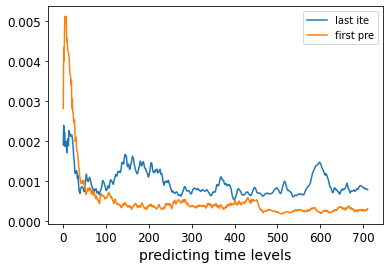

In [ ]:
plt.plot(loss_11)
plt.plot(loss_12)
plt.xlabel('predicting time levels')
plt.legend(['last ite','first pre'])

Text(0.5, 1.0, 'Mean loss of data assimilation')

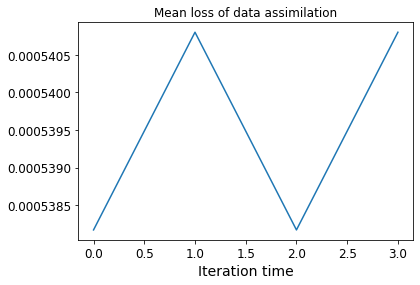

In [ ]:
plt.plot(da)
plt.xlabel('Iteration time')
plt.title('Mean loss of data assimilation')

In [ ]:
pod_pred_da = X_predict[:,:ncoeffs]
pod_pred = X_predict_1[:,:ncoeffs]
# sensors_pred_da = X_predict_12[:,ncoeffs:-3]
# sensors_pred = X_predict_11[:,ncoeffs:-3]
sensors_pred_da = X_predict[:,ncoeffs:-3]
sensors_pred = X_predict_1[:,ncoeffs:-3]
X = np.hsplit(sensors_pred, 7)
X_da = np.hsplit(sensors_pred_da, 7)
Ps_CO2 = scalar_1_CO2.inverse_transform(X[0])
Ps_CO2_da = scalar_1_CO2.inverse_transform(X_da[0])
Ps_x = scalar_1_velocity_x.inverse_transform(X[1])
Ps_x_da = scalar_1_velocity_x.inverse_transform(X_da[1])
Ps_y = scalar_1_velocity_y.inverse_transform(X[2])
Ps_y_da = scalar_1_velocity_x.inverse_transform(X_da[2])
Ps_z = scalar_1_velocity_z.inverse_transform(X[3])
Ps_z_da = scalar_1_velocity_z.inverse_transform(X_da[3])
Ps_t = scalar_1_temperature.inverse_transform(X[4])
Ps_t_da = scalar_1_temperature.inverse_transform(X_da[4])
Ps_h = scalar_1_humidity.inverse_transform(X[5])
Ps_h_da = scalar_1_humidity.inverse_transform(X_da[5])
Ps_v = scalar_1_virus1.inverse_transform(X[6])
Ps_v_da = scalar_1_virus1.inverse_transform(X_da[6])
# Undo (0,1) scaling
X_gen = scaler_pca_model.inverse_transform(pod_pred)
X_gen_da = scaler_pca_model.inverse_transform(pod_pred_da)
# Undo PCA to obtain a scaled snapshot matrix
X_rec = pca_model.inverse_transform(X_gen)
X_rec_da = pca_model.inverse_transform(X_gen_da)

# Split to CO2 and three dimensions of velocity data
X_pod = np.hsplit(X_rec, 7)
X_pod_da = np.hsplit(X_rec_da, 7)
# Undo (−1,1) scaling
S_CO2 = scaler_model_CO2_1.inverse_transform(X_pod[0])
S_CO2_da = scaler_model_CO2_1.inverse_transform(X_pod_da[0])
S_x = scaler_model_Velocity_x_1.inverse_transform(X_pod[1])
S_x_da = scaler_model_Velocity_x_1.inverse_transform(X_pod_da[1])
S_y = scaler_model_Velocity_y_1.inverse_transform(X_pod[2])
S_y_da = scaler_model_Velocity_y_1.inverse_transform(X_pod_da[2])
S_z = scaler_model_Velocity_z_1.inverse_transform(X_pod[3])
S_z_da = scaler_model_Velocity_z_1.inverse_transform(X_pod_da[3])
S_t = scaler_model_Temperature_1.inverse_transform(X_pod[4])
S_t_da = scaler_model_Temperature_1.inverse_transform(X_pod_da[4])
S_h = scaler_model_Humidity_1.inverse_transform(X_pod[5])
S_h_da = scaler_model_Humidity_1.inverse_transform(X_pod_da[5])
S_v = scaler_model_Virus1_1.inverse_transform(X_pod[6])
S_v_da = scaler_model_Virus1_1.inverse_transform(X_pod_da[6])
# Undo PCA to obtain a scaled snapshot matrix
X_real = pca_model.inverse_transform(X_pca_1)
# Split to CO2 and three dimensions of velocity data
Real = np.hsplit(X_real, 7)
Real_sen = np.hsplit(norm_sensor_1,7)
# Undo (−1,1) scaling
R_CO2 = scaler_model_CO2_1.inverse_transform(Real[0])
R_x = scaler_model_Velocity_x_1.inverse_transform(Real[1])
R_y = scaler_model_Velocity_y_1.inverse_transform(Real[2])
R_z = scaler_model_Velocity_z_1.inverse_transform(Real[3])
R_t = scaler_model_Temperature_1.inverse_transform(Real[4])
R_h = scaler_model_Humidity_1.inverse_transform(Real[5])
R_v = scaler_model_Virus1_1.inverse_transform(Real[6])

Rs_CO2 = scalar_1_CO2.inverse_transform(Real_sen[0])
Rs_x = scalar_1_velocity_x.inverse_transform(Real_sen[1])
Rs_y = scalar_1_velocity_y.inverse_transform(Real_sen[2])
Rs_z = scalar_1_velocity_z.inverse_transform(Real_sen[3])
Rs_t = scalar_1_temperature.inverse_transform(Real_sen[4])
Rs_h = scalar_1_humidity.inverse_transform(Real_sen[5])
Rs_v = scalar_1_virus1.inverse_transform(Real_sen[6])

np.shape(Real_sen)

(7, 720, 18)

In [ ]:
# x_axis=np.linspace(0,1800,360)
x_axis=np.linspace(0,3600,720)
def sensor_plot(X_predict_da, X_predict, real, fields):
  fig, ax = plt.subplots(1,4, figsize=[24,4])
  fig.tight_layout(h_pad=3.5, w_pad=3.5)
  for i in range(4):
      ax.flatten()[i].plot(x_axis,X_predict_da[:,i*2], '-')
      ax.flatten()[i].plot(x_axis,X_predict[:,i*2], '-')
      ax.flatten()[i].plot(x_axis,real[:,i*2], '-')
      ax.flatten()[i].plot(x_axis,real[:,i*2], '-')
      # ax.flatten()[i].plot(x_axis,real[:,i*2], '-')
      ax.flatten()[i].legend(['Prediction with da', 'Prediction', 'Fluidity','Observation data'])
      ax.flatten()[i].set_title('Sensor '+ str(i*2+1))
      ax.flatten()[i].set_xlabel('Time(s)')
      ax.flatten()[i].set_ylabel(fields)  

def pod_plot(X_predict_da, X_predict, real, fields):
  fig, ax = plt.subplots(1,4, figsize=[24,4])
  fig.tight_layout(h_pad=3.5, w_pad=3.5)
  for i in range(4):
      ax.flatten()[i].plot(x_axis,X_predict_da[:,i*200], '-')
      ax.flatten()[i].plot(x_axis,X_predict[:,i*200], '-')
      ax.flatten()[i].plot(x_axis,real[:,i*200], '-')
      ax.flatten()[i].plot(x_axis,real[:,i*200], '-')
      # ax.flatten()[i].plot(x_axis,real[:,i*200], '-')
      ax.flatten()[i].legend(['Prediction with da', 'Prediction', 'Fluidity','Observation data'])
      ax.flatten()[i].set_title('Node '+ str(i*100+1))
      ax.flatten()[i].set_xlabel('Time(s)')
      ax.flatten()[i].set_ylabel(fields) 

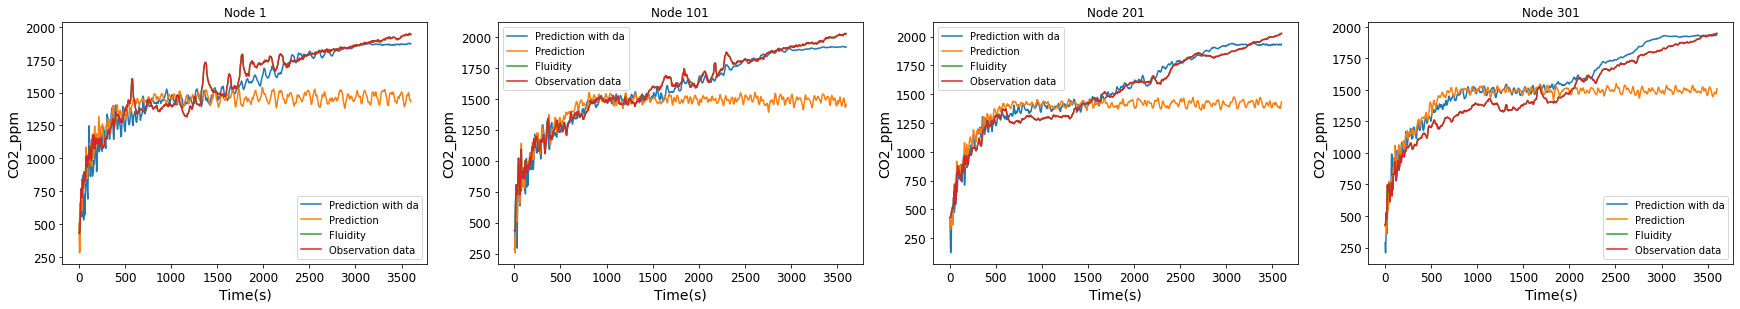

In [ ]:
pod_plot(S_CO2_da,S_CO2,R_CO2,'CO2_ppm')

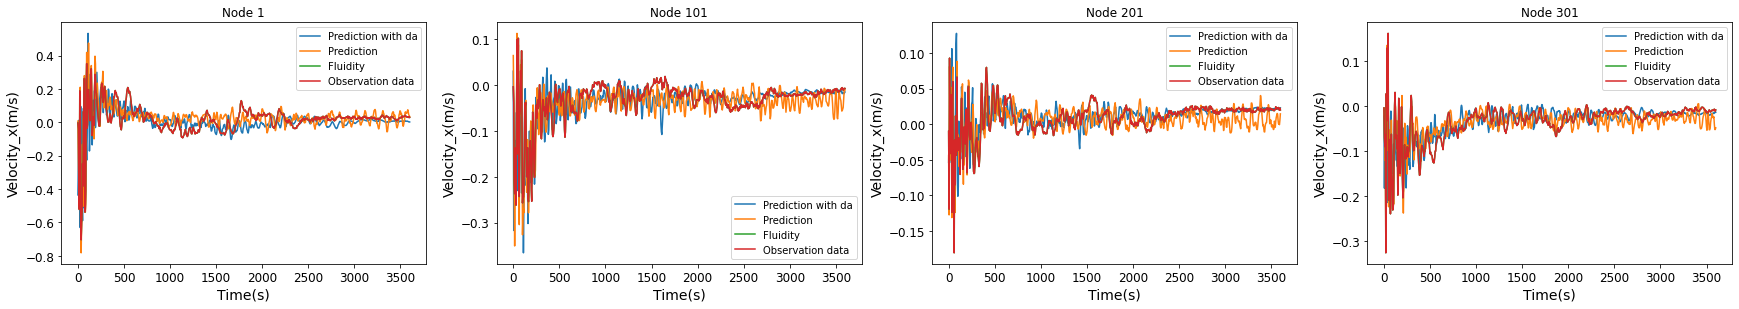

In [ ]:
pod_plot(S_x_da,S_x,R_x,'Velocity_x(m/s)')

In [ ]:
pod_plot(S_y_da,S_y,R_y,'Velocity_y(m/s)')

In [ ]:
pod_plot(S_z_da,S_z,R_z,'Velocity_z(m/s)')

In [ ]:
pod_plot(S_t_da,S_t,R_t,'Temperature(k)')

In [ ]:
pod_plot(S_h_da,S_h,R_h,'Humidity')

In [ ]:
pod_plot(S_v_da,S_v,R_v,'virus load')

In [ ]:
sensor_plot(Ps_CO2_da,Ps_CO2,Rs_CO2,'CO2_ppm')

In [ ]:
sensor_plot(Ps_x_da,Ps_x,Rs_x,'Velocity_x(m/s)')

In [ ]:
sensor_plot(Ps_y_da,Ps_y,Rs_y,'Velocity_y(m/s)')

In [ ]:
sensor_plot(Ps_z_da,Ps_z,Rs_z,'Velocity_z(m/s)')

In [ ]:
sensor_plot(Ps_t_da,Ps_t,Rs_t,'Temperature')

In [ ]:
sensor_plot(Ps_h_da,Ps_h,Rs_h,'Humidity')

# Control cases

## different control on cases

In [ ]:
for j in range(1,6):
  # Undo PCA to obtain a scaled snapshot matrix
  locals()['pca_model_'+str(j)] = joblib.load('pca_model_time576_com95_'+str(j)+'.pkl')
  locals()['X_real_'+str(j)] = locals()['pca_model_'+str(j)].inverse_transform(locals()['X_pca_'+str(j)])
  # Split to CO2 and three dimensions of velocity data
  locals()['Real_'+str(j)] = np.hsplit(locals()['X_real_'+str(j)], 7)
  locals()['Real_sen_'+str(j)] = np.hsplit(locals()['norm_sensor_'+str(j)],7)
  # Undo (−1,1) scaling
  locals()['R_CO2_'+str(j)] = locals()['scaler_model_CO2_'+str(j)].inverse_transform(locals()['Real_'+str(j)][0])
  locals()['R_x_'+str(j)] = locals()['scaler_model_Velocity_x_'+str(j)].inverse_transform(locals()['Real_'+str(j)][1])
  locals()['R_y_'+str(j)] = locals()['scaler_model_Velocity_y_'+str(j)].inverse_transform(locals()['Real_'+str(j)][2])
  locals()['R_z_'+str(j)] = locals()['scaler_model_Velocity_z_'+str(j)].inverse_transform(locals()['Real_'+str(j)][3])
  locals()['R_t_'+str(j)] = locals()['scaler_model_Temperature_'+str(j)].inverse_transform(locals()['Real_'+str(j)][4])
  locals()['R_h_'+str(j)] = locals()['scaler_model_Humidity_'+str(j)].inverse_transform(locals()['Real_'+str(j)][5])
  locals()['R_v_'+str(j)] = locals()['scaler_model_Virus1_'+str(j)].inverse_transform(locals()['Real_'+str(j)][6])

In [ ]:
fan = np.array([[0.5,0.5,0.5,1.0,0.25],[1.0,1.0,1.0,2.0,0.5],[0.8,0.3,1.3,0.8,0.8]])

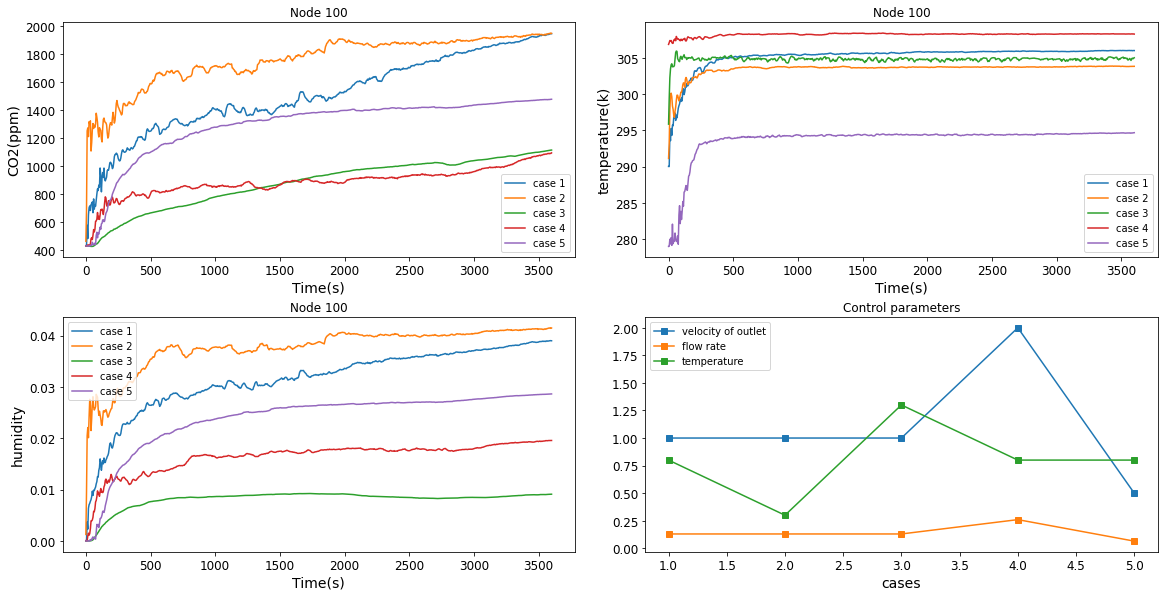

In [ ]:
fig, ax = plt.subplots(2,2, figsize=[16,8])
fig.tight_layout(h_pad=3.5, w_pad=3.5)
x_axis = np.linspace(0,720*5,720)
x_axis2 = np.arange(1,6,1)
for j in range(1,6):
  ax.flatten()[0].plot(x_axis,locals()['R_CO2_'+str(j)][:,100], '-')
  ax.flatten()[1].plot(x_axis,locals()['R_t_'+str(j)][:,100], '-')
  ax.flatten()[2].plot(x_axis,locals()['R_v_'+str(j)][:,100], '-')
 
ax.flatten()[0].legend(['case 1','case 2', 'case 3','case 4','case 5'])
ax.flatten()[0].set_title('Node '+ str(100))
ax.flatten()[0].set_xlabel('Time(s)')
ax.flatten()[0].set_ylabel('CO2(ppm)')
ax.flatten()[1].legend(['case 1','case 2', 'case 3','case 4','case 5'])
ax.flatten()[1].set_title('Node '+ str(100))
ax.flatten()[1].set_xlabel('Time(s)')
ax.flatten()[1].set_ylabel('temperature(k)')
ax.flatten()[2].legend(['case 1','case 2', 'case 3','case 4','case 5'])
ax.flatten()[2].set_title('Node '+ str(100))
ax.flatten()[2].set_xlabel('Time(s)')
ax.flatten()[2].set_ylabel('humidity')
ax.flatten()[3].set_title('Control parameters')
ax.flatten()[3].set_xlabel('cases')
ax.flatten()[3].plot(x_axis2,fan[1],'-s')
ax.flatten()[3].plot(x_axis2,fan[1]*0.13,'-s')
ax.flatten()[3].plot(x_axis2,fan[2],'-s')
ax.flatten()[3].legend(['velocity of outlet','flow rate', 'temperature'])

## method 1

In [ ]:
def control(real_coding,pred_steps,control_parameters,for_or_back='backward'):
  time_steps = pred_steps + ntimes
  real_coding = real_coding[:,:codings_size*(ntimes - 1)]
  real_coding = real_coding.reshape((1, ntimes - 1, codings_size, 1))
  # set initial values
  loss = []
  for i in range(pred_steps):
    if(for_or_back=='backward'):
      initial_pred = np.concatenate((real_coding[:,:1,:,:],real_coding), axis=1)
    else:
      initial_pred = np.concatenate((real_coding, real_coding[:,-1:,:,:]), axis=1)
    
    #forward prediction
    if(for_or_back == 'forward'):
      prediction_values,loss_i = control_coding_forward(initial_pred, real_coding,control_parameters)
      gen_predict = prediction_values[:,(ntimes - 1):,:,:]
      loss.append(loss_i[-1])
      if i==0 :
        X_predict = list(prediction_values.numpy().reshape(-1,codings_size))
      else:
        X_predict.append(gen_predict.numpy().flatten())
      real_coding = np.concatenate((real_coding[:,1:,:,:], gen_predict), axis=1)
    #backward prediction
    else:
      prediction_values,loss_i = control_coding_backward(initial_pred, real_coding,control_parameters)
      gen_predict = prediction_values[:,:1,:,:]
      loss.append(loss_i[-1])
      if i==0:
        X_predict = list(prediction_values.numpy().reshape(-1,codings_size))
      else:
        X_predict.insert(0,gen_predict.numpy().flatten())
      real_coding = np.concatenate((gen_predict, real_coding[:,:(ntimes - 2),:,:]), axis=1)
  X_predict = np.array(X_predict)
  loss = np.array(loss)
  return X_predict, loss

In [ ]:
X_predict_da = X_predict.copy()
control_parameters = fan_2[:9,:]
con = []
for j in range(5):
  print(j,' backward')
  real_coding = X_predict_da[-8:,].reshape((1, ntimes - 1, X_train_concat.shape[2], 1))
  X_predict_da,loss_da = control(real_coding,forward_steps,control_parameters,for_or_back='backward')
  con.append(loss_da.mean())
  print('loss da: ',loss_da)
  print(j,' forward')
  real_coding = X_predict_da[:8,].reshape((1, ntimes - 1, X_train_concat.shape[2], 1))
  X_predict_da,loss_da = control(real_coding,forward_steps,control_parameters,for_or_back='forward')
  con.append(loss_da.mean())
  print('loss da: ',loss_da)
  if j>0:
    if con[-1]-con[-2]<1e-3 and con[-1]<1e-2:
      break

0  backward
loss da:  [0.00036448 0.00033138 0.00032837 0.00030379 0.00029652 0.00028227
 0.00029197 0.00030156 0.00031596 0.000326   0.00032746 0.00034462
 0.00036142 0.00038045 0.00039542 0.00040452 0.00040627 0.00041219
 0.00041016 0.00039622 0.00037518 0.00035707 0.00034204 0.00032955
 0.00032053 0.00031789 0.00032175 0.00032618 0.00032554 0.00031826
 0.00030826 0.00029999 0.00029522 0.00029337 0.00029308 0.00029168
 0.00028923 0.00028585 0.00028169 0.00027603 0.00026979 0.00026448
 0.00026198 0.00026129 0.00026173 0.00026136 0.00025917 0.00025856
 0.0002611  0.00026593 0.00027079 0.00027416 0.00027522 0.00027455
 0.00027299 0.00027226 0.00027135 0.0002707  0.00026947 0.00026704
 0.00026377 0.00026132 0.00026014 0.00025924 0.00025793 0.00025645
 0.00025495 0.00025375 0.0002534  0.00025402 0.00025605 0.00025983
 0.0002636  0.00026628 0.00026699 0.00026615 0.00026382 0.00026187
 0.00026038 0.00025911 0.00025843 0.00025785 0.00025734 0.00025704
 0.00025616 0.00025494 0.00025417 0.0002

## method 2

In [ ]:
def control_gd(real_coding,pred_steps,control_parameters,for_or_back='backward'):
  time_steps = pred_steps + ntimes
  real_coding = real_coding[:,:codings_size*(ntimes - 1)]
  real_coding = real_coding.reshape((1, ntimes - 1, codings_size, 1))
  # set initial values
  loss = []
  for i in range(pred_steps):
    if(for_or_back=='backward'):
      initial_pred = np.concatenate((real_coding[:,:1,:,:],real_coding), axis=1)
    else:
      initial_pred = np.concatenate((real_coding, real_coding[:,-1:,:,:]), axis=1)
    
    #forward prediction
    if(for_or_back == 'forward'):
      prediction_values,loss_i = control_gd_forward(initial_pred, real_coding,control_parameters)
      gen_predict = prediction_values[:,(ntimes - 1):,:,:]
      loss.append(loss_i[-1])
      if i==0 :
        X_predict = list(prediction_values.numpy().reshape(-1,codings_size))
      else:
        X_predict.append(gen_predict.numpy().flatten())
      real_coding = np.concatenate((real_coding[:,1:,:,:], gen_predict), axis=1)
    #backward prediction
    else:
      prediction_values,loss_i = control_gd_backward(initial_pred, real_coding,control_parameters)
      gen_predict = prediction_values[:,:1,:,:]
      loss.append(loss_i[-1])
      if i==0:
        X_predict = list(prediction_values.numpy().reshape(-1,codings_size))
      else:
        X_predict.insert(0,gen_predict.numpy().flatten())
      real_coding = np.concatenate((gen_predict, real_coding[:,:(ntimes - 2),:,:]), axis=1)
  X_predict = np.array(X_predict)
  loss = np.array(loss)
  return X_predict, loss

In [ ]:
X_predict_da1 = X_predict_12.copy()
control_parameters = fan_2[:9,:]
con = []
for j in range(5):
  print(j,' backward')
  real_coding = X_predict_da1[-8:,].reshape((1, ntimes - 1, X_train_concat.shape[2], 1))
  X_predict_da1,loss_da1 = control_gd(real_coding,forward_steps,control_parameters,for_or_back='backward')
  con.append(loss_da1.mean())
  print('loss da: ',loss_da1)
  print(j,' forward')
  real_coding = X_predict_da1[:8,].reshape((1, ntimes - 1, X_train_concat.shape[2], 1))
  X_predict_da1,loss_da1 = control_gd(real_coding,forward_steps,control_parameters,for_or_back='forward')
  con.append(loss_da1.mean())
  print('loss da: ',loss_da1)
  if j>0:
    if con[-1]-con[-2]<1e-3 and con[-1]<1e-2:
      break

0  backward
loss da:  [0.00087131 0.00082383 0.00079346 0.00076715 0.00073633 0.00071114
 0.00069214 0.00067397 0.00064786 0.00063416 0.00063548 0.00063668
 0.00062633 0.00062168 0.00061486 0.00061165 0.00061661 0.00060798
 0.00059148 0.00055304 0.00051792 0.00050133 0.00050304 0.00051833
 0.00051801 0.00050529 0.00049269 0.00049158 0.00050748 0.00053865
 0.00059468 0.00065643 0.00073152 0.00078363 0.0008203  0.00082106
 0.00083249 0.00084653 0.00085826 0.00083355 0.00081984 0.00082173
 0.00082843 0.00084601 0.00086658 0.00088144 0.00092167 0.00093329
 0.00093434 0.00092748 0.00092904 0.00093873 0.00096779 0.0009771
 0.00096586 0.00094568 0.00090163 0.00084371 0.00081245 0.00081144
 0.00085776 0.00088898 0.00091871 0.00095442 0.00095795 0.00094009
 0.00093318 0.000914   0.00091686 0.00093256 0.00093711 0.00096002
 0.0009735  0.00101844 0.00104479 0.001074   0.00111446 0.00113359
 0.00115388 0.00119597 0.0012591  0.00130929 0.00133708 0.00131244
 0.00126993 0.00127182 0.00131113 0.00129

### plot

In [ ]:
pod_pred_da = X_predict_da1[:,:ncoeffs]
pod_pred = X_predict_12[:,:ncoeffs]
# Undo (0,1) scaling
X_gen = scaler_pca_model.inverse_transform(pod_pred)
X_gen_da = scaler_pca_model.inverse_transform(pod_pred_da)
# Undo PCA to obtain a scaled snapshot matrix
X_rec = pca_model_1.inverse_transform(X_gen)
X_rec_da = pca_model_2.inverse_transform(X_gen_da)

# Split to CO2 and three dimensions of velocity data
X_pod = np.hsplit(X_rec, 7)
X_pod_da = np.hsplit(X_rec_da, 7)
# Undo (−1,1) scaling
S_CO2 = scaler_model_CO2_1.inverse_transform(X_pod[0])
S_CO2_da = scaler_model_CO2_2.inverse_transform(X_pod_da[0])
S_x = scaler_model_Velocity_x_1.inverse_transform(X_pod[1])
S_x_da = scaler_model_Velocity_x_2.inverse_transform(X_pod_da[1])
S_y = scaler_model_Velocity_y_1.inverse_transform(X_pod[2])
S_y_da = scaler_model_Velocity_y_2.inverse_transform(X_pod_da[2])
S_z = scaler_model_Velocity_z_1.inverse_transform(X_pod[3])
S_z_da = scaler_model_Velocity_z_2.inverse_transform(X_pod_da[3])
S_t = scaler_model_Temperature_1.inverse_transform(X_pod[4])
S_t_da = scaler_model_Temperature_2.inverse_transform(X_pod_da[4])
S_h = scaler_model_Humidity_1.inverse_transform(X_pod[5])
S_h_da = scaler_model_Humidity_2.inverse_transform(X_pod_da[5])

In [4]:
# fig, ax = plt.subplots(3,2, figsize=[16,12])
# fig.tight_layout(h_pad=3.5, w_pad=3.5)
for i in range(6):
    ax.flatten()[i].plot(x_axis,S_t[:,i*200], '-')
    ax.flatten()[i].plot(x_axis,S_t_da[:,i*200], '-')
    ax.flatten()[i].plot(x_axis,R_t[:,i*200], '-')
    ax.flatten()[i].legend(['Prediction','Prediction with control', 'case 2'])
    ax.flatten()[i].set_title('Node '+ str(i*200+1))
    ax.flatten()[i].set_xlabel('Time level(1 = 30s)')
    ax.flatten()[i].set_ylabel('temperature')  

NameError: ignored

# Save predictions in vtu files

In [ ]:
! pip install vtk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88.3 MB 162 kB/s 


In [ ]:
import vtktools
from tools_io import get_nNodes_from_vtu, get_clean_vtu_file

def write_example_to_vtu(exm_num):
    # get clean vtu file
    snapshot_data_location = '/content/drive/MyDrive/cases/'
    snapshot_file_base = 'Cotrace_fixed_'
    filename = snapshot_data_location + snapshot_file_base + '1.vtu'
    clean_vtu = get_clean_vtu_file(filename)

    # write results to vtu
    nNodes = get_nNodes_from_vtu(snapshot_data_location, snapshot_file_base)
    CO2_ppm = np.zeros((nNodes,1))
    velocity = np.zeros((nNodes,3))
    temperature = np.zeros((nNodes,1))
    humidity = np.zeros((nNodes,1))

    new_vtu = vtktools.vtu()
    new_vtu.ugrid.DeepCopy(clean_vtu.ugrid)
    new_vtu.filename = 'prediction/Prediction_'  + str(exm_num) + '.vtu'

    CO2_ppm[:] = S_CO2[exm_num].reshape((54363, 1),order='F')
    velocity[:,0] = S_x[exm_num].reshape((54363),order='F')
    velocity[:,1] = S_y[exm_num].reshape((54363),order='F') 
    velocity[:,2] = S_z[exm_num].reshape((54363),order='F')
    temperature[:] = S_t[exm_num].reshape((54363, 1),order='F')
    humidity[:] = S_h[exm_num].reshape((54363, 1),order='F')



    new_vtu.AddField('CO2_ppm', CO2_ppm)
    new_vtu.AddField('Velocity', velocity)
    new_vtu.AddField('Temperature', temperature)
    new_vtu.AddField('Humidity', humidity)

    new_vtu.Write()

In [ ]:
S_CO2.shape

(720, 54363)

In [ ]:
start = 0
end = 720
for i in range(start,end):
    write_example_to_vtu(i)
    print('Finished', i)

Finished 0
Finished 1
Finished 2
Finished 3
Finished 4
Finished 5
Finished 6
Finished 7
Finished 8
Finished 9
Finished 10
Finished 11
Finished 12
Finished 13
Finished 14
Finished 15
Finished 16
Finished 17
Finished 18
Finished 19
Finished 20
Finished 21
Finished 22
Finished 23
Finished 24
Finished 25
Finished 26
Finished 27
Finished 28
Finished 29
Finished 30
Finished 31
Finished 32
Finished 33
Finished 34
Finished 35
Finished 36
Finished 37
Finished 38
Finished 39
Finished 40
Finished 41
Finished 42
Finished 43
Finished 44
Finished 45
Finished 46
Finished 47
Finished 48
Finished 49
Finished 50
Finished 51
Finished 52
Finished 53
Finished 54
Finished 55
Finished 56
Finished 57
Finished 58
Finished 59
Finished 60
Finished 61
Finished 62
Finished 63
Finished 64
Finished 65
Finished 66
Finished 67
Finished 68
Finished 69
Finished 70
Finished 71
Finished 72
Finished 73
Finished 74
Finished 75
Finished 76
Finished 77
Finished 78
Finished 79
Finished 80
Finished 81
Finished 82
Finished 83
Fi

In [ ]:
import vtktools
from tools_io import get_nNodes_from_vtu, get_clean_vtu_file

def write_example_to_vtu_da(exm_num):
    # get clean vtu file
    snapshot_data_location = '/content/drive/MyDrive/cases/'
    snapshot_file_base = 'Cotrace_fixed_'
    filename = snapshot_data_location + snapshot_file_base + '1.vtu'
    clean_vtu = get_clean_vtu_file(filename)

    # write results to vtu
    nNodes = get_nNodes_from_vtu(snapshot_data_location, snapshot_file_base)
    CO2_ppm = np.zeros((nNodes,1))
    velocity = np.zeros((nNodes,3))
    temperature = np.zeros((nNodes,1))
    humidity = np.zeros((nNodes,1))

    new_vtu = vtktools.vtu()
    new_vtu.ugrid.DeepCopy(clean_vtu.ugrid)
    new_vtu.filename = 'prediction/DA_' + str(exm_num) + '.vtu'

    CO2_ppm[:] = S_CO2_da[exm_num].reshape((54363, 1),order='F')
    velocity[:,0] = S_x_da[exm_num].reshape((54363),order='F')
    velocity[:,1] = S_y_da[exm_num].reshape((54363),order='F') 
    velocity[:,2] = S_z_da[exm_num].reshape((54363),order='F')
    temperature[:] = S_t_da[exm_num].reshape((54363, 1),order='F')
    humidity[:] = S_h_da[exm_num].reshape((54363, 1),order='F')

    new_vtu.AddField('CO2_ppm', CO2_ppm)
    new_vtu.AddField('Velocity', velocity)
    new_vtu.AddField('Temperature', temperature)
    new_vtu.AddField('Humidity', humidity)

    new_vtu.Write()

In [ ]:
start = 0
end = 720
for i in range(start,end):
    write_example_to_vtu_da(i)
    print('Finished', i)

Finished 0
Finished 1
Finished 2
Finished 3
Finished 4
Finished 5
Finished 6
Finished 7
Finished 8
Finished 9
Finished 10
Finished 11
Finished 12
Finished 13
Finished 14
Finished 15
Finished 16
Finished 17
Finished 18
Finished 19
Finished 20
Finished 21
Finished 22
Finished 23
Finished 24
Finished 25
Finished 26
Finished 27
Finished 28
Finished 29
Finished 30
Finished 31
Finished 32
Finished 33
Finished 34
Finished 35
Finished 36
Finished 37
Finished 38
Finished 39
Finished 40
Finished 41
Finished 42
Finished 43
Finished 44
Finished 45
Finished 46
Finished 47
Finished 48
Finished 49
Finished 50
Finished 51
Finished 52
Finished 53
Finished 54
Finished 55
Finished 56
Finished 57
Finished 58
Finished 59
Finished 60
Finished 61
Finished 62
Finished 63
Finished 64
Finished 65
Finished 66
Finished 67
Finished 68
Finished 69
Finished 70
Finished 71
Finished 72
Finished 73
Finished 74
Finished 75
Finished 76
Finished 77
Finished 78
Finished 79
Finished 80
Finished 81
Finished 82
Finished 83
Fi

In [ ]:
import vtktools
from tools_io import get_nNodes_from_vtu, get_clean_vtu_file

def write_example_to_vtu_da(exm_num):
    # get clean vtu file
    snapshot_data_location = '/content/drive/MyDrive/cases/'
    snapshot_file_base = 'Cotrace_fixed_'
    filename = snapshot_data_location + snapshot_file_base + '1.vtu'
    clean_vtu = get_clean_vtu_file(filename)

    # write results to vtu
    nNodes = get_nNodes_from_vtu(snapshot_data_location, snapshot_file_base)
    CO2_ppm = np.zeros((nNodes,1))
    velocity = np.zeros((nNodes,3))
    temperature = np.zeros((nNodes,1))
    humidity = np.zeros((nNodes,1))

    new_vtu = vtktools.vtu()
    new_vtu.ugrid.DeepCopy(clean_vtu.ugrid)
    new_vtu.filename = 'prediction/Real_' + str(exm_num) + '.vtu'

    CO2_ppm[:] = R_CO2[exm_num].reshape((54363, 1),order='F')
    velocity[:,0] = R_x[exm_num].reshape((54363),order='F')
    velocity[:,1] = R_y[exm_num].reshape((54363),order='F') 
    velocity[:,2] = R_z[exm_num].reshape((54363),order='F')
    temperature[:] = R_t[exm_num].reshape((54363, 1),order='F')
    humidity[:] = R_h[exm_num].reshape((54363, 1),order='F')

    new_vtu.AddField('CO2_ppm', CO2_ppm)
    new_vtu.AddField('Velocity', velocity)
    new_vtu.AddField('Temperature', temperature)
    new_vtu.AddField('Humidity', humidity)

    new_vtu.Write()

In [ ]:
start = 0
end = 720
for i in range(start,end):
    write_example_to_vtu_da(i)
    print('Finished', i)

Finished 0
Finished 1
Finished 2
Finished 3
Finished 4
Finished 5
Finished 6
Finished 7
Finished 8
Finished 9
Finished 10
Finished 11
Finished 12
Finished 13
Finished 14
Finished 15
Finished 16
Finished 17
Finished 18
Finished 19
Finished 20
Finished 21
Finished 22
Finished 23
Finished 24
Finished 25
Finished 26
Finished 27
Finished 28
Finished 29
Finished 30
Finished 31
Finished 32
Finished 33
Finished 34
Finished 35
Finished 36
Finished 37
Finished 38
Finished 39
Finished 40
Finished 41
Finished 42
Finished 43
Finished 44
Finished 45
Finished 46
Finished 47
Finished 48
Finished 49
Finished 50
Finished 51
Finished 52
Finished 53
Finished 54
Finished 55
Finished 56
Finished 57
Finished 58
Finished 59
Finished 60
Finished 61
Finished 62
Finished 63
Finished 64
Finished 65
Finished 66
Finished 67
Finished 68
Finished 69
Finished 70
Finished 71
Finished 72
Finished 73
Finished 74
Finished 75
Finished 76
Finished 77
Finished 78
Finished 79
Finished 80
Finished 81
Finished 82
Finished 83
Fi